In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes, tree
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('modeling_data.csv', index_col = 'id')

In [3]:
df.head()

,created_at,deadline,launched_at,sub_category,goal_usd,campaign_duration,create_to_launch_duration,Failed,region_AM_non_US,region_AP,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
id,,,,,,,,,,,,,,,,,,,,,
1846656783,2020-04-16 05:18:45,2020-05-15 01:58:55,2020-04-24 01:58:55,Children's Books,3410.199225,21,7,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1091394927,2020-05-27 06:47:29,2020-07-09 09:00:00,2020-06-09 09:14:06,Product Design,5000.000000,29,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1892452780,2020-04-15 07:11:52,2020-07-13 05:22:08,2020-06-13 05:22:08,Product Design,7700.000000,30,58,0,0,0,...,0,0,0,0,0,0,0,0,0,0
591954572,2016-12-27 13:19:41,2020-04-23 19:33:00,2020-03-24 10:02:22,Product Design,10000.000000,30,1182,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1488247508,2020-07-17 19:34:35,2020-08-26 23:59:00,2020-07-28 08:05:39,Product Design,10000.000000,29,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    0.768566
1    0.231434
Name: Failed, dtype: float64


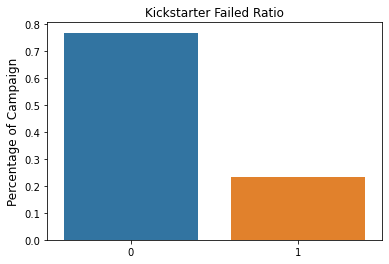

In [4]:
target = df.Failed.value_counts(normalize=True) 
print(target)
sns.barplot(target.index, target.values)
plt.title('Kickstarter Failed Ratio')
plt.ylabel('Percentage of Campaign', fontsize=12);

### Data splitting train/val/test

In [5]:
df_m = df.drop(['created_at', 'deadline', 'launched_at', 'sub_category'], axis=1)

In [6]:
X, y = df_m.drop(['Failed'], axis=1), df_m.Failed

X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.4,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5,random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)

scaler = StandardScaler()
X_val_sc = scaler.fit_transform(X_val)

scaler = StandardScaler()
X_test_sc = scaler.fit_transform(X_test)

# Model 1: KNN - GridSearchCV

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
# define the parameter values that should be searched
k_range = list(range(1, 21))
weight_options = ['uniform', 'distance']

In [9]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'weights': ['uniform', 'distance']}


In [10]:
# Train on training set, and Test on testing set
knn = KNeighborsClassifier(n_neighbors=5)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='f1')
grid.fit(X_train_sc, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [11]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'n_neighbors': 13, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=13)
Best score:  0.5212659144665286


In [12]:
# Train on best parameters and get score on validation data
knn = KNeighborsClassifier(n_neighbors=13, weights='uniform')
knn.fit(X_train_sc, y_train)

knn_pred = knn.predict(X_val_sc)
knn_confusion = confusion_matrix(y_val,knn_pred)

knn_ac = knn.score(X_val_sc, y_val)
knn_precision = precision_score(y_val, knn_pred)
knn_recall = recall_score(y_val, knn_pred)
knn_f1 = f1_score(y_val, knn_pred)

print(classification_report(y_val, knn_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4906
           1       0.69      0.48      0.57      1485

    accuracy                           0.83      6391
   macro avg       0.77      0.71      0.73      6391
weighted avg       0.82      0.83      0.82      6391



In [13]:
knn_confusion

array([[4576,  330],
       [ 766,  719]])

In [14]:
# Start to make a dict of scores for each model
f1_scores = {}
f1_scores['knn_f1'] = knn_f1

recall_scores = {}
recall_scores['knn_recall'] = knn_recall

In [93]:
knn_y_score = knn.predict_proba(X_val_sc)[:,1]
knn_fpr, knn_tpr, knn_auc_thresholds = roc_curve(y_val, knn_y_score)
roc_auc_knn = auc(knn_fpr, knn_tpr)
print(roc_auc_knn)

0.8204847084790012


# Model 2: Logistic Regression - GridSearchCV

In [15]:
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
lr = LogisticRegression()
lr_grid = GridSearchCV(lr, param_grid = grid_values, scoring = 'f1')
lr_grid.fit(X_train_sc, y_train)
lr_grid_preds = lr_grid.predict(X_val_sc)

lr_grid_best_params = lr_grid.best_params_
lr_grid_best_estimator = lr_grid.best_estimator_
lr_grid_best_cm = confusion_matrix(y_val,lr_grid_preds)
lr_grid_best_cr = classification_report(y_val,lr_grid_preds)
print(lr_grid_best_params, lr_grid_best_estimator, lr_grid_best_cm, lr_grid_best_cr)

{'C': 1, 'penalty': 'l2'} LogisticRegression(C=1) [[4516  390]
 [ 883  602]]               precision    recall  f1-score   support

           0       0.84      0.92      0.88      4906
           1       0.61      0.41      0.49      1485

    accuracy                           0.80      6391
   macro avg       0.72      0.66      0.68      6391
weighted avg       0.78      0.80      0.79      6391



In [16]:
lr_grid_best_cm

array([[4516,  390],
       [ 883,  602]])

In [17]:
lr_grid_best_params

{'C': 1, 'penalty': 'l2'}

In [18]:
classification_report(y_val,lr_grid_preds)

'              precision    recall  f1-score   support\n\n           0       0.84      0.92      0.88      4906\n           1       0.61      0.41      0.49      1485\n\n    accuracy                           0.80      6391\n   macro avg       0.72      0.66      0.68      6391\nweighted avg       0.78      0.80      0.79      6391\n'

In [19]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

In [20]:
f1_score(y_val, lr_grid_preds)

0.4860718611223254

In [21]:
recall_score(y_val, lr_grid_preds)

0.4053872053872054

In [22]:
f1_scores['LR_f1'] = f1_score(y_val, lr_grid_preds)
recall_scores['LR_recall'] = recall_score(y_val, lr_grid_preds)

In [23]:
f1_scores

{'knn_f1': 0.5674822415153907, 'LR_f1': 0.4860718611223254}

In [24]:
recall_scores

{'knn_recall': 0.4841750841750842, 'LR_recall': 0.4053872053872054}

In [96]:
lr_y_score = lr_grid.predict_proba(X_val_sc)[:,1]
lr_fpr, lr_tpr, lr_auc_thresholds = roc_curve(y_val, lr_y_score)
roc_auc_lr = auc(lr_fpr, lr_tpr)
print(roc_auc_lr)

0.8033636404814554


# Model 3: Decision Tree

In [25]:
# No need to scale feature magnitude for DT and RF
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_val)

dt_ac = dt.score(X_val, y_val)
dt_precision = precision_score(y_val, dt_pred)
dt_recall = recall_score(y_val, dt_pred)
dt_f1 = f1_score(y_val, dt_pred)

print(classification_report(y_val, dt_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4906
           1       0.52      0.53      0.52      1485

    accuracy                           0.78      6391
   macro avg       0.69      0.69      0.69      6391
weighted avg       0.78      0.78      0.78      6391



In [26]:
print('Decision Tree validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (dt_ac, 
         dt_precision, 
         dt_recall,
         dt_f1)
     )

Decision Tree validation metrics: 
 Accuracy: 0.7753 
 Precision: 0.5160 
 Recall: 0.5333 
 F1: 0.5245


In [28]:
f1_scores['DT_f1'] = dt_f1
recall_scores['DT_recall'] = dt_recall

In [31]:
print(confusion_matrix(y_val, dt_pred))

[[4163  743]
 [ 693  792]]


In [98]:
dt_y_score = dt.predict_proba(X_val)[:, 1]
dt_fpr, dt_tpr, auc_thresholds = roc_curve(y_val, dt_y_score)
roc_auc_dt = auc(dt_fpr, dt_tpr)
print(roc_auc_dt)

0.6916938785874783


# Model 4: Random Forest - GridSearchCV

In [66]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

rf_ac = rf.score(X_val, y_val)
rf_precision = precision_score(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred)

rf_y_score = rf.predict_proba(X_val)[:, 1]
rf_fpr, rf_tpr, auc_thresholds = roc_curve(y_val, rf_y_score)
roc_auc_rf = auc(rf_fpr, rf_tpr)

print(classification_report(y_val, rf_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4906
           1       0.68      0.54      0.60      1485

    accuracy                           0.83      6391
   macro avg       0.77      0.73      0.75      6391
weighted avg       0.82      0.83      0.83      6391



In [67]:
print('Random Forest validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (rf_ac, 
         rf_precision, 
         rf_recall,
         rf_f1,
         roc_auc_rf)
     )

Random Forest validation metrics: 
 Accuracy: 0.8329 
 Precision: 0.6757 
 Recall: 0.5401 
 F1: 0.6003 
 ROC: 0.8403


In [68]:
confusion_matrix(y_val, rf_pred)

array([[4521,  385],
       [ 683,  802]])

In [69]:
f1_scores['RF_f1'] = rf_f1
recall_scores['RF_recall'] = rf_recall

### Model 4.2: RF Parameter tuning

In [58]:
# # from sklearn.model_selection import RandomizedSearchCV
# # # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# # # Number of features to consider at every split
# # max_features = ['auto', 'sqrt']
# # # Maximum number of levels in tree
# # max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# # max_depth.append(None)
# # # Minimum number of samples required to split a node
# # min_samples_split = [2, 5, 10]
# # # Minimum number of samples required at each leaf node
# # min_samples_leaf = [1, 2, 4]
# # # Method of selecting samples for training each tree
# # bootstrap = [True, False]
# # #Criterion
# criterion = ['gini', 'entropy']
# # # Create the random grid
# # random_grid = {'n_estimators': n_estimators,
# #                'max_features': max_features,
# #                'max_depth': max_depth,
# #                'min_samples_split': min_samples_split,
# #                'min_samples_leaf': min_samples_leaf,
# #                'bootstrap': bootstrap,
# #               'critertion': criterion}
# param_grid = { 
#     'n_estimators': n_estimators,
#     'criterion' :['gini', 'entropy']
# }

In [59]:
# # Use the random grid to search for best hyperparameters 
# rf_random = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, 
#                                scoring = 'f1', verbose=2, n_jobs=-1)
# rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780,
                                          890, 1000]},
             scoring='f1', verbose=2)

In [60]:
# rf_grid_preds = rf_random.predict(X_val)
# rf_best_params = rf_random.best_params_
# rf_best_estimator = rf_random.best_estimator_
# rf_best_cm = confusion_matrix(y_val,rf_grid_preds)
# rf_best_cr = classification_report(y_val,rf_grid_preds)
# print(rf_best_params, rf_best_estimator, rf_best_cm, rf_best_cr)

{'criterion': 'gini', 'n_estimators': 450} RandomForestClassifier(n_estimators=450) [[4512  394]
 [ 696  789]]               precision    recall  f1-score   support

           0       0.87      0.92      0.89      4906
           1       0.67      0.53      0.59      1485

    accuracy                           0.83      6391
   macro avg       0.77      0.73      0.74      6391
weighted avg       0.82      0.83      0.82      6391



In [70]:
# rf_ac = rf_random.score(X_val, y_val)
# rf_precision = precision_score(y_val, rf_grid_preds)
# rf_recall = recall_score(y_val, rf_grid_preds)
# rf_f1 = f1_score(y_val, rf_grid_preds)

# print('Random Forest validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
#         (rf_ac, 
#          rf_precision, 
#          rf_recall,
#          rf_f1,
#          roc_auc_rf)
#      )

Random Forest validation metrics: 
 Accuracy: 0.5915 
 Precision: 0.6669 
 Recall: 0.5313 
 F1: 0.5915 
 ROC: 0.8403


In [71]:
# confusion_matrix(y_val, rf_grid_preds)

# Model 5: XGBoost

In [72]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_val)

xg_ac = xg.score(X_val, y_val)
xg_precision = precision_score(y_val, xg_pred)
xg_recall = recall_score(y_val, xg_pred)
xg_f1 = f1_score(y_val, xg_pred)

xg_y_score = xg.predict_proba(X_val)[:, 1]
xg_fpr, xg_tpr, auc_thresholds = roc_curve(y_val, xg_y_score)
roc_auc_xg = auc(xg_fpr, xg_tpr)

print(classification_report(y_val, xg_pred))

[11:02:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4906
           1       0.73      0.51      0.60      1485

    accuracy                           0.84      6391
   macro avg       0.80      0.73      0.75      6391
weighted avg       0.83      0.84      0.83      6391



In [73]:
print('XGBoost validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (xg_ac, 
         xg_precision, 
         xg_recall,
         xg_f1,
         roc_auc_xg)
     )


XGBoost validation metrics: 
 Accuracy: 0.8435 
 Precision: 0.7325 
 Recall: 0.5145 
 F1: 0.6044 
 ROC: 0.8561


In [74]:
confusion_matrix(y_val, xg_pred)

array([[4627,  279],
       [ 721,  764]])

## Model 5.2: XGBoost - Initial Parameter Tuning

In [79]:
param_grid= dict(
    max_depth = list(range(5, 7)),
    learning_rate = [0.1, 0.3],
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
)
xg_grid_search = XGBClassifier()
xg_grid = GridSearchCV(xg_grid_search, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
xg_grid.fit(X_train, y_train)
xg_grid_pred = xg_grid.predict(X_val)

xg_best_params = xg_grid.best_params_
xg_best_estimator = xg_grid.best_estimator_
xg_best_cm = confusion_matrix(y_val, xg_grid_pred)
xg_best_cr = classification_report(y_val, xg_grid_pred)

print(xg_best_params)
print(xg_best_estimator)
print('confusion matrix:')
print(xg_best_cm)
print(xg_best_cr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[11:23:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 255}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=255, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
confusion matrix:
[[4644  262]
 [ 721  764]]
       

In [85]:
xg_ac = xg_grid.score(X_val, y_val)
xg_precision = precision_score(y_val, xg_grid_pred)
xg_recall = recall_score(y_val, xg_grid_pred)
xg_f1 = f1_score(y_val, xg_grid_pred)

xg_y_score = xg_grid.predict_proba(X_val)[:, 1]
xg_fpr, xg_tpr, auc_thresholds = roc_curve(y_val, xg_y_score)
roc_auc_xg = auc(xg_fpr, xg_tpr)

print(classification_report(y_val, xg_grid_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.90      4906
           1       0.74      0.51      0.61      1485

    accuracy                           0.85      6391
   macro avg       0.81      0.73      0.76      6391
weighted avg       0.84      0.85      0.84      6391



In [86]:
print('XGBoost validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC: %.4f' %
        (xg_ac, 
         xg_precision, 
         xg_recall,
         xg_f1,
         roc_auc_xg)
     )


XGBoost validation metrics: 
 Accuracy: 0.6085 
 Precision: 0.7446 
 Recall: 0.5145 
 F1: 0.6085 
 ROC: 0.8607


In [87]:
confusion_matrix(y_val, xg_pred)

array([[4627,  279],
       [ 721,  764]])

In [88]:
f1_scores['xgb_f1'] = xg_f1
recall_scores['xgb_recall'] = xg_recall

# Model comparison graphs

### Do a graph of the scores for f1 and recall

In [102]:
import warnings
warnings.filterwarnings('ignore')

In [103]:
recall_scores

{'knn_recall': 0.4841750841750842,
 'LR_recall': 0.4053872053872054,
 'DT_recall': 0.5333333333333333,
 'RF_recall': 0.54006734006734,
 'xgb_recall': 0.5144781144781144}

In [104]:
f1_scores

{'knn_f1': 0.5674822415153907,
 'LR_f1': 0.4860718611223254,
 'DT_f1': 0.5245033112582781,
 'RF_f1': 0.6002994011976047,
 'xgb_f1': 0.6085225009956192}

In [105]:
scores_dict = {'KNN': [f1_scores['knn_f1'], recall_scores['knn_recall']],
              'LR': [f1_scores['LR_f1'], recall_scores['LR_recall']],
              'DT': [f1_scores['DT_f1'], recall_scores['DT_recall']],
              'RF': [f1_scores['RF_f1'], recall_scores['RF_recall']],
              'XGB': [f1_scores['xgb_f1'], recall_scores['xgb_recall']]}

In [106]:
scores_dict

{'KNN': [0.5674822415153907, 0.4841750841750842],
 'LR': [0.4860718611223254, 0.4053872053872054],
 'DT': [0.5245033112582781, 0.5333333333333333],
 'RF': [0.6002994011976047, 0.54006734006734],
 'XGB': [0.6085225009956192, 0.5144781144781144]}

In [123]:
scores_df = pd.DataFrame.from_dict(scores_dict, orient = 'index',columns = ['F1', 'Recall'])

In [124]:
scores_df

,F1,Recall
KNN,0.567482,0.484175
LR,0.486072,0.405387
DT,0.524503,0.533333
RF,0.600299,0.540067
XGB,0.608523,0.514478


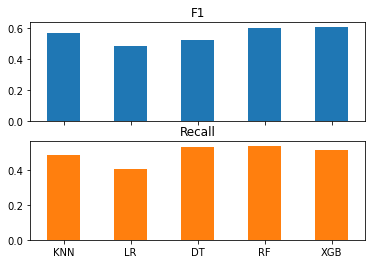

In [150]:
axes = scores_df.plot.bar(rot=0, subplots=True, legend = '') 


### ROC Curve comparison

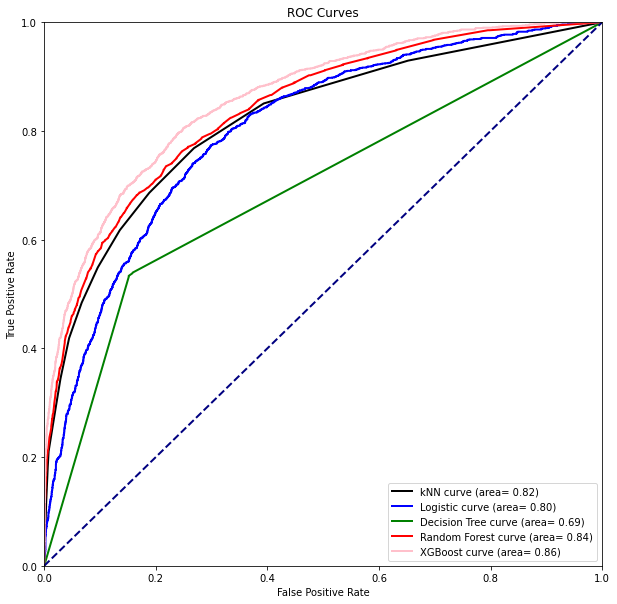

In [119]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(knn_fpr, knn_tpr, color='black', lw=lw, 
         label='kNN curve (area= %0.2f)' %roc_auc_knn)
plt.plot(lr_fpr, lr_tpr, color='blue', lw=lw, 
         label='Logistic curve (area= %0.2f)' %roc_auc_lr)
plt.plot(dt_fpr, dt_tpr, color='green', lw=lw, 
         label='Decision Tree curve (area= %0.2f)' %roc_auc_dt)
plt.plot(rf_fpr, rf_tpr, color='red', lw=lw, 
         label='Random Forest curve (area= %0.2f)' %roc_auc_rf)
plt.plot(xg_fpr, xg_tpr, color='pink', lw=lw,
        label='XGBoost curve (area= %0.2f)' %roc_auc_xg)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

plt.savefig('roc_curve.png', dpi = 500, bbox_inches='tight')